### Exercise 5 ###

Implement function tha takes S and $\gamma$ and solve the graphical LASSO

In [18]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
def solver(S, gamma):

    if not np.allclose(S, S.T):
        raise ValueError("Matrix S must be symmetric.")
    if gamma < 0:
        raise ValueError("Gamma must be non-negative.")

    n = S.shape[0]

    X = cp.Variable((n, n), symmetric=True)

    trace_term = cp.trace(S @ X)
    logdet_term = -cp.log_det(X)

    # L1 penalty on off-diagonal elements
    off_diag_l1 = cp.norm1(cp.vec(X) - cp.vec(cp.diag(cp.diag(X))))

    # Full objective
    objective = cp.Minimize(trace_term + logdet_term + gamma * off_diag_l1)

    # Constraint: X must be positive definite
    constraints = [X >> 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
        
    print("Optimal X:")
    print(X.value)
    return X.value

### Exercise 6 ###
Given the S matrix compute th epoints on thr trade - off curve

In [15]:
S = np.array([
    [1.00, -0.50,  0.10, -0.90],
    [-0.50, 1.25, -0.05,  1.05],
    [0.10, -0.05,  0.26, -0.09],
    [-0.90, 1.05, -0.09,  5.17]
])

In [16]:
def trade_off(S, gammas, method):

    x_points = []
    y_points = []

    for gamma in gammas:

        X = method(S, gamma)

        x_points.append(np.trace(S @ X) - np.log(np.linalg.det(X)))

        off_diag_mask = ~np.eye(X.shape[0], dtype=bool)
        off_diag_l1 = np.sum(np.abs(X[off_diag_mask]))
        
        y_points.append(off_diag_l1)


    plt.figure(figsize=(8, 6))
    plt.plot(x_points, y_points, marker='o', label='Trade-off Curve')
    plt.xlabel('Trace - LogDet')
    plt.ylabel('L1 Norm of Off-Diagonal Elements')
    plt.title('Trade-off Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


Optimal X:
[[ 1.35863123e+00  3.96322950e-01 -3.57286131e-01  1.48624394e-01]
 [ 3.96322950e-01  1.07922066e+00 -1.16859424e-09 -1.48870982e-01]
 [-3.57286131e-01 -1.16859424e-09  3.96984799e+00  1.15885992e-09]
 [ 1.48624394e-01 -1.48870982e-01  1.15885992e-09  2.48947819e-01]]
Optimal X:
[[ 1.34514439e+00  3.87395428e-01 -3.29249378e-01  1.47709401e-01]
 [ 3.87395428e-01  1.07223152e+00 -9.75338925e-09 -1.48116948e-01]
 [-3.29249378e-01 -9.75338925e-09  3.95166650e+00 -2.62909678e-09]
 [ 1.47709401e-01 -1.48116948e-01 -2.62909678e-09  2.48255918e-01]]
Optimal X:
[[ 1.32400447e+00  3.72860572e-01 -2.83269089e-01  1.46190179e-01]
 [ 3.72860572e-01  1.06093826e+00 -2.84653441e-09 -1.46859770e-01]
 [-2.83269089e-01 -2.84653441e-09  3.92477414e+00  6.36815409e-09]
 [ 1.46190179e-01 -1.46859770e-01  6.36815409e-09  2.47116953e-01]]
Optimal X:
[[ 1.29235698e+00  3.49549900e-01 -2.08394017e-01  1.43675321e-01]
 [ 3.49549900e-01  1.04306872e+00 -3.77876556e-09 -1.44765470e-01]
 [-2.08394017e-

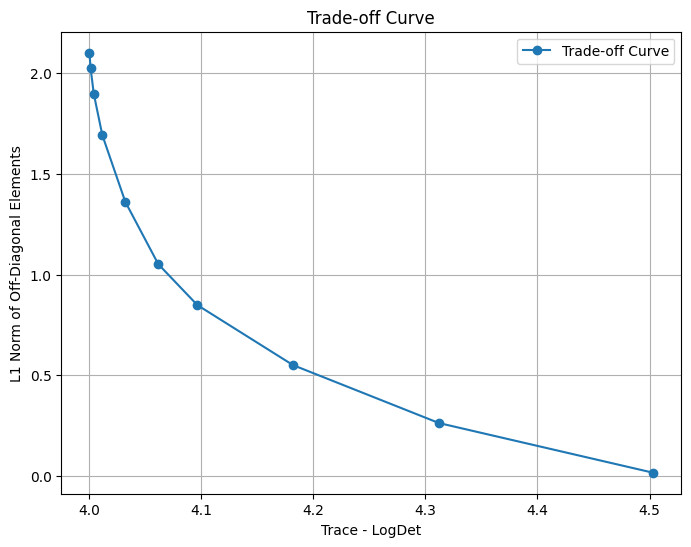

In [17]:
gammas = np.logspace(-2, 0, 10)

trade_off(S, gammas, solver)

### Exercise 7 ###

Implement proximal gradient method for solving graphical LASSO problem

In [24]:
from numpy.linalg import inv, norm, slogdet

def prox_h(X, t, gamma):
    """Proximal operator for h(X) = gamma * sum_{i != j} |X_ij|"""
    X_new = X.copy()
    n = X.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j:
                X_new[i, j] = np.sign(X[i, j]) * max(abs(X[i, j]) - t * gamma, 0)
    return X_new

def g(X, S):
    """Smooth part of the objective function"""
    sign, logdet = slogdet(X)
    if sign <= 0:
        return np.inf
    return np.trace(S @ X) - logdet

def grad_g(X, S):
    """Gradient of g(X) = tr(SX) - logdet(X)"""
    return S - inv(X)

def dual_variable(X, S, gamma):
    """Compute dual variable U"""
    X_inv = inv(X)
    U = X_inv - S
    n = X.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                U[i, j] = 0
            else:
                U[i, j] = np.clip(U[i, j], -gamma, gamma)
    return U

def duality_gap(X, S, gamma):
    """Compute the duality gap"""
    g_val = g(X, S)
    h_val = gamma * np.sum(np.abs(X - np.diag(np.diag(X))))
    U = dual_variable(X, S, gamma)
    try:
        sign, logdet = slogdet(S + U)
        if sign <= 0:
            return np.inf
        gap = g_val + h_val - logdet - X.shape[0]
    except np.linalg.LinAlgError:
        gap = np.inf
    return gap

def graphical_lasso_proximal_gradient(S, gamma, epsilon=1e-2, max_iter=1000):
    """Proximal gradient method with backtracking for graphical LASSO"""
    n = S.shape[0]
    X = np.eye(n)
    for k in range(max_iter):
        G = grad_g(X, S)
        t = 1.0  # initial step size
        beta = 0.5
        alpha = 0.5
        
        # Backtracking line search
        while True:
            Y = prox_h(X - t * G, t, gamma)
            diff = Y - X
            lhs = g(Y, S)
            rhs = g(X, S) + np.sum(G * diff) + (1 / (2 * t)) * norm(diff, 'fro')**2
            if lhs <= rhs and np.all(np.linalg.eigvalsh(Y) > 0):
                break
            t *= beta

        X = Y
        gap = duality_gap(X, S, gamma)
        if gap < epsilon:
            break
    return X

### Exercise 8 ###

Find the precision matrix of given data while varying the $\gamma$

In [25]:
matrix = np.loadtxt('data/sp500.txt')

gammas = np.logspace(-2, -1, 10)

trade_off(matrix, gammas, graphical_lasso_proximal_gradient)

KeyboardInterrupt: 

In [26]:
graphical_lasso_proximal_gradient(matrix, 0.1)

KeyboardInterrupt: 